# Generating Images with Generative Adversarial Networks (GANs)

The purpose of the project is to test the ability of Generative Adversial Networks (GANs) in generating realistic-looking images. 

## Dataset

The dataset used will be FashionMNIST. It contains low resolution ($28 \times 28$) grey-scale images representing different kind of clothes. The dataset is available on keras and accessable in $\texttt{tf.keras.datasets.fashion\_mnist}$. Note that the pixel values for the images are initially in the interval $[0, 255]$. It is required to normalize them since all of the algorithm we will use require them to be in that format. To be fair, you will find the dataset already normalized, do not modify that part of the code.

## Metrics

Measuring the quality of newly generated images is a non-trivial task. Indeed, there is no label associated to each image, and thus it is impossible to measure the quality image-by-image. For that reason, common metrics uses statistical consideration on a generated dataset to test how well the network recovered the statistics of the original data. One of the most common is the Fréchet Inception Distance (FID). The idea of FID is that in a realistic-looking dataset of images, the statistics of the activation of the last hidden layer in a well-trained classificator should be similar to that of a dataset containing real images. Specifically, regarding FID, the Inception-v3 network is used as a classificator. A real dataset $\mathbb{D}_r$ and a generated dataset $\mathbb{D}_g$ are processed by the network, and the activation of the last hidden layer has mean and variance $(\mu_r, \Sigma_r)$, $(\mu_g, \Sigma_g)$ respectively. Then, FID is computed as:

$$
    FID(\mathbb{D}_r, \mathbb{D}_g) = || \mu_r - \mu_g ||^2 + Tr(\Sigma_r + \Sigma_g - 2(\Sigma_r \ast \Sigma_g)^{\frac{1}{2}}) 
$$

A Python implementation of FID can be found in the file $\texttt{fid.py}$ that you find attached on Virtuale. Its usage is very simple, just generate $10k$ fake images with your GAN, and with the command $\texttt{fid.get\_fid(x\_test, x\_gen)}$, where $\texttt{x\_test}$ is the test set, containing $10k$ real images, you get the value for the FID of your network. Remember that, when passed through that function, $\texttt{x\_gen}$ **must** be a dataset of $10k$ images, in the interval $[0, 1]$. The number of $10k$ images is fundamental, since the value of FID strongly depends on the number of input images.

## Limitations

You are required to implement a vanilla Generative Adversarial Network (GAN), not a variant of it (e.g. PixelGAN, CycleGAN, ... are **not** accepted). The maximum number of parameters is *15 million*, and every pre-trained network can be used as an add-on (the number of parameters for pre-trained network does not count). Clearly, only the training set can be used to train the network, no additional images (Data Augmentation is ok).

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

The images are normalized in $[0, 1]$. For simplicity, images are padded to have dimension $32 \times 32$.

In [ ]:
# Load the data. Note that the labels y_train and y_test are not loaded since not required.
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize and pad the datasets
x_train = np.pad(x_train, ((0,0), (2,2), (2,2)))
x_train = np.reshape(x_train, x_train.shape + (1, ))
x_train = x_train / 255.

x_test = np.pad(x_test, ((0,0), (2,2), (2,2)))
x_test = np.reshape(x_test, x_test.shape + (1, ))
x_test = x_test / 255.

print(f"Training shape: {x_train.shape}, Training pixel values: {x_train.min(), x_train.max()}")
print(f"Test shape: {x_test.shape}, Test pixel values: {x_test.min(), x_test.max()}")

4431872/4422102 [==============================] - 0s 0us/step
Training shape: (60000, 32, 32, 1), Training pixel values: (0.0, 1.0)
Test shape: (10000, 32, 32, 1), Test pixel values: (0.0, 1.0)


Now, we import the functions for the computation of the FID, and we test that FID(x_train, x_test) is low.

_Note: Computing the FID function requires some minutes. Consequently, it is suggested to comment this cell after you tested once, to reduce the execution time of the notebook. To speed-up the process, after a first use, the function will generate a file containing the value of the activations of the test set, so that it does not have to compute it again every time._ 

**Remember that, when you use the FID function, the first input MUST be the test set, while the second will be the generated images set.**

In [ ]:
"""
Do not modify this code. This is just for utilities.
"""

import os
from tensorflow.keras.applications.inception_v3 import InceptionV3

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3), weights='imagenet')

def get_inception_activations(inps, batch_size=100):
    """
    Compute the activation for the model Inception v3 for a given input 'inps'.

    Note: inps is assumed to be normalized in [0, 1].
    """
    n_batches = inps.shape[0] // batch_size

    act = np.zeros([inps.shape[0], 2048], dtype=np.float32)
    for i in range(n_batches):
        # Load a batch of data
        inp = inps[i * batch_size:(i + 1) * batch_size]

        # Resize each image to match the input shape of Inception v3
        inpr = tf.image.resize(inp, (299, 299))

        # Resize images in the interval [-1, 1], given that inpr is in [0, 1].
        inpr = inpr * 2 - 1 

        # Predict the activation
        act[i * batch_size:(i + 1) * batch_size] = model.predict(inpr, steps=1)

        print(f"Processed {str((i + 1) * batch_size)} images.")
    return act


def get_fid(images1, images2):
    """
    Compute the FID between two sets of images.

    Note: it can take several minutes.
    """
    from scipy.linalg import sqrtm

    shape = np.shape(images1)[1]
    print("Computing FID for {} dimensional images".format(images1.shape))

    # Inception v3 requires the input to have 3 channel. If this is not the
    # case, just copy the same channel three times.
    if images1.shape[-1] == 1:
        images1 = np.concatenate([images1, images1, images1], axis=-1)
        images2 = np.concatenate([images2, images2, images2], axis=-1)

    # activation for true images is always the same: we just compute it once
    if os.path.exists("act_mu.npy"):
        mu1 = np.load("act_mu.npy")
        sigma1 = np.load("act_sigma.npy")
    else:
        act1 = get_inception_activations(images1)
        mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
        np.save("act_mu.npy", mu1)
        np.save("act_sigma.npy", sigma1)
    print('Done stage 1 of 2')

    act2 = get_inception_activations(images2)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    print('Done stage 2 of 2')

    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # compute sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Compute the FID between the Test set and (the first 10k images of) Train set (should be low)
train_fid = get_fid(x_test, x_train[:10_000])

# Print out the results
print(f"FID(x_test, x_train) = {train_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processed 3900 images.
Processed 4000 images.
Processed 4100 images.
Processed 

# Good work!

In [ ]:
# importing important libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
%matplotlib inline

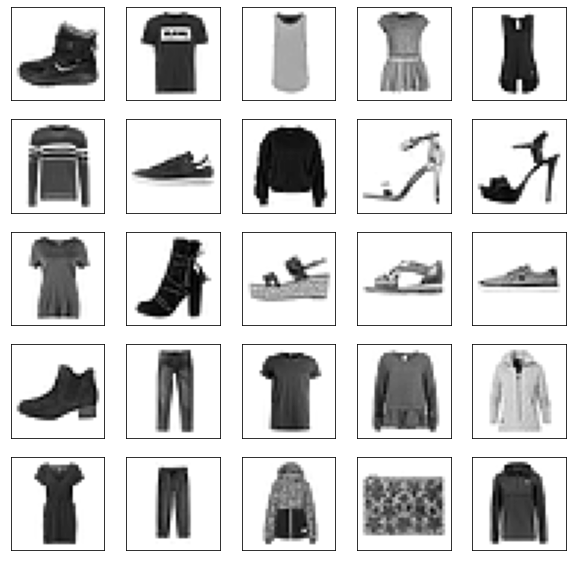

In [ ]:
# visualizing training samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
plt.show()

In [ ]:
# preparing dataset for training
# setting datatype to be uniformly float 32 throughout this notebook
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
num_features = 100 #number of dimensions of the input latent variable space(noise)

In [ ]:
def define_generator(latent_size):
    alpha=0.2 # parameter for LeakyReLU
    model = tf.keras.Sequential(
        [
            layers.Dense(8 * 8 * 128, input_dim=latent_size),
            layers.LeakyReLU(alpha),
            layers.Reshape((8, 8, 128)),
            
            layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                                   kernel_initializer='glorot_normal'),    # upscaling
            layers.LeakyReLU(alpha),
            layers.BatchNormalization(),
            
            layers.Conv2DTranspose(128, 4, strides=2, padding='same',
                                   kernel_initializer='glorot_normal'),
            layers.LeakyReLU(alpha),
            layers.BatchNormalization(),
            
            layers.Conv2D(1, 8, padding='same',
                          activation='tanh',
                          kernel_initializer='glorot_normal'),
        ]
    )
    
    return model
generator = define_generator(num_features)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_94 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                       

In [ ]:
# output of generator on a random noise
noise = tf.random.normal(shape=(1,num_features), dtype=tf.dtypes.float64)
generated_image = generator(noise, training=False)

In [ ]:
def define_discriminator():
    # using conatant dropout and LeakyReLU parameters throughout the discriminator
    alpha=0.2 # parameter for LeakyReLU
    drop_out=0.5 # parameter for Dropout
    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, 3, strides=2, padding='same',
                          input_shape=(32, 32, 1)),       # input shape is same as that of the image
            layers.LeakyReLU(alpha),
            layers.Dropout(drop_out),
            
            layers.Conv2D(64, 3, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha),
            layers.Dropout(drop_out),
            
            layers.Conv2D(128, 3, strides=2, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha),
            layers.Dropout(drop_out),
            
            layers.Conv2D(256, 3, padding='same'),
            layers.BatchNormalization(),
            layers.LeakyReLU(alpha),
            layers.Dropout(drop_out),
            
            layers.GlobalMaxPooling2D(),
            layers.Dense(1, activation='sigmoid')
        ]
    )
    
    return model

discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_96 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_96 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                      

In [ ]:
# creating the GAN (combining generator and discriminator)
# batch normalization and LeakyReLU have been used as a part of architecture
# This Vanila GAN consists of Conv2D and Conv2DTranspose layers.
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
seed = tf.random.normal(shape=(batch_size, num_features))

In [ ]:
# training function
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=(batch_size, num_features))
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0) #input for discriminator
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #output for discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
# function for printing output images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary') #rescaling the pixel values back to 0-255 range
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
x_train_dc_gan = x_train.reshape(-1, 32, 32, 1) * 2 - 1 #rescaling corectly so that there is no discrepancy in any function

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train_dc_gan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

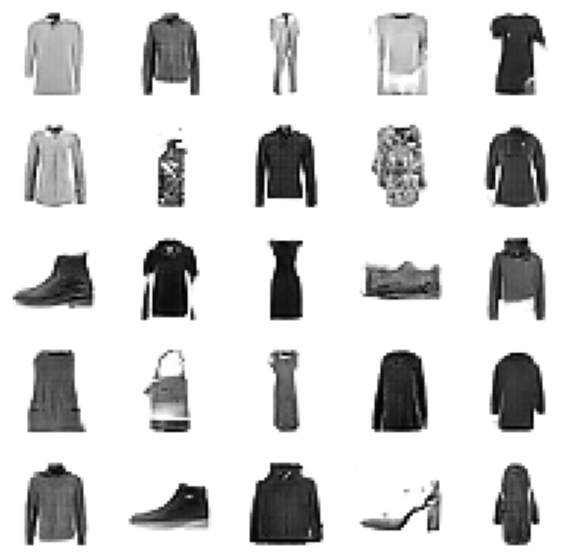

In [ ]:
train_dcgan(gan, dataset, batch_size, num_features, epochs=70)

In [ ]:
# saving the model
generator.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# obtaining 10,000 generated images
predictions = []
for i in range(10):
  noise = tf.random.normal(shape=(1000, num_features))
  pred_batch = generator(noise, training=False)
  predictions.extend(pred_batch)

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out

In [ ]:
# rescaling images to [0, 1]
for a in range(len(predictions)):
  predictions[a] = np.array(predictions[a])
  for b in range(len(predictions[a])):
    predictions[a][b]=denorm(predictions[a][b])

In [ ]:
test_fid = get_fid(x_test, predictions)

# Print out the results
print(f"FID(x_test, predictions ) = {test_fid}")

Computing FID for (10000, 32, 32, 1) dimensional images
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
Processed 2000 images.
Processed 2100 images.
Processed 2200 images.
Processed 2300 images.
Processed 2400 images.
Processed 2500 images.
Processed 2600 images.
Processed 2700 images.
Processed 2800 images.
Processed 2900 images.
Processed 3000 images.
Processed 3100 images.
Processed 3200 images.
Processed 3300 images.
Processed 3400 images.
Processed 3500 images.
Processed 3600 images.
Processed 3700 images.
Processed 3800 images.
Processed 3900 images.
Processed 4000 images.
Processed 4100 images.
Processed 

The obtained fid score was- 17.54679027522328